In [73]:
from typing import Literal
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, END
from langgraph.types import Command
import os
from langchain_anthropic import ChatAnthropic


members = ["general ai", "code ai", "HR ai", "product ai"]

options = members

system_prompt = """You are a supervisor tasked with managing a conversation between the following workers: {members}. 
    If the message is about scaleway products (the cloud provider), then take model product ai. 
    If the message is about a human resources topic for a scaleway employee, then take HR ai. 
    If the message is about IT development then take code ai. 
    Finally, if none of the above applies, default to general ai."""


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


llm = ChatOpenAI(
    base_url=os.environ.get("SCW_GENERATIVE_APIs_ENDPOINT"),
    api_key=os.environ.get("SCW_SECRET_KEY_PERSO"),
    model="llama-3.1-70b-instruct",
)


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm_english.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    return Command(goto=goto, update={"next": goto})

In [74]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent


llm_agent = create_react_agent(llm, tools=[])


def worker_general(state: State) -> Command[Literal["__end__"]]:
    result = llm_agent.invoke(state)
    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content)]},
        goto=END,
    )



def worker_code(state: State) -> Command[Literal["__end__"]]:
    result = llm_agent.invoke(state)
    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content)]},
        goto=END,
    )


def worker_HR(state: State) -> Command[Literal["__end__"]]:
    result = llm_agent.invoke(state)
    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content)]},
        goto=END,
    )



def worker_product(state: State) -> Command[Literal["__end__"]]:
    result = llm_agent.invoke(state)
    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content)]},
        goto=END,
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("general ai", worker_general)
builder.add_node("code ai", worker_code)
builder.add_node("HR ai", worker_HR)
builder.add_node("product ai", worker_product)
graph = builder.compile()

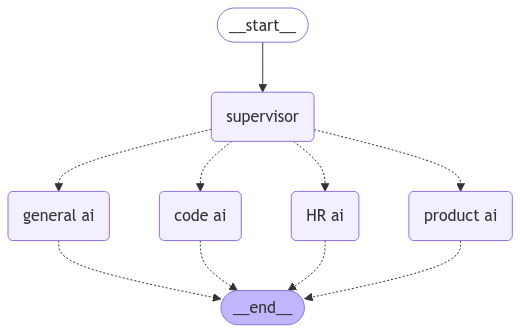

In [75]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [76]:
config = {"configurable": {"thread_id": "1"}}


def inference(user_input: str):
    events = graph.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        config,
        stream_mode="values",
    )
    for event in events:
        if "next" in event.keys():
            event["messages"][-1].pretty_print()

            if len(event["messages"]) > 1:
                print("From :", event["next"])

In [77]:
inference("Hey, mon nom est Hugo")


================================ Human Message =================================

Hey, mon nom est Hugo
================================ Human Message =================================

Bonjour Hugo, comment puis-je vous aider aujourd'hui ?
From : general ai


In [ ]:
questions = [
    {"model": "Product AI", "question": "Comment creer une instance Scaleway ?"},
    {"model": "Product AI", "question": "Comment fonctionne la tarification des instances GPU chez Scaleway ?"},
    {"model": "Product AI", "question": "Quels sont les services managés proposés par Scaleway pour le stockage de données ?"},
    
    {"model": "HR AI", "question": "Quelles sont les politiques de congés chez Scaleway ?"},
    {"model": "HR AI", "question": "Comment fonctionne le processus d'onboarding pour un nouvel employé chez Scaleway ?"},
    {"model": "HR AI", "question": "Quels sont les avantages sociaux offerts aux employés de Scaleway ?"},
    
    {"model": "Code AI", "question": "Comment configurer une CI/CD pipeline avec GitLab pour un projet hébergé chez Scaleway ?"},
    {"model": "Code AI", "question": "Quelles sont les meilleures pratiques pour optimiser une API FastAPI en production ?"},
    {"model": "Code AI", "question": "Comment utiliser Kubernetes pour déployer une application sur un cluster Scaleway ?"},
    
    {"model": "General AI", "question": "Quels sont les derniers progrès en intelligence artificielle ?"},
    {"model": "General AI", "question": "Quel était le rôle des Médicis dans le développement de la Renaissance italienne ?"},
    {"model": "General AI", "question": "Pourquoi le Mont Everest grandit-il chaque année ?"}
]

In [72]:
for q in questions: 
    inference(q)

================================ Human Message =================================

Comment fonctionne la tarification des instances GPU chez Scaleway ?
================================ Human Message =================================

Je ne peux pas fournir des informations précises sur la tarification des instances GPU chez Scaleway.
From : product ai
================================ Human Message =================================

Comment fonctionne le processus d'onboarding pour un nouvel employé chez Scaleway ?
================================ Human Message =================================

Je n'ai pas d'informations spécifiques sur le processus d'onboarding pour un nouvel employé chez Scaleway. Cependant, je peux vous dire que le processus d'onboarding est généralement la même pour la plupart des entreprises.

Il est probable que le processus d'onboarding chez Scaleway commence par une procédure d'intégration administrative, suivi d'une présentation de l'entreprise, de ses valeurs 

In [69]:
for s in graph.stream(
    {"messages": [("user", "Donne moi une question de culture general.")]},
    subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'general ai'}})
----
(('general ai:f8726119-468c-c146-a334-9d91bbe20aa9',), {'agent': {'messages': [AIMessage(content='Quel est le nom du peintre qui a créé la célèbre toile "La Nuit étoilée" ?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 106, 'total_tokens': 135, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'meta/llama-3.1-70b-instruct:fp8', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-71fda0d4-a012-4ae0-9340-de45d30aeea6-0', usage_metadata={'input_tokens': 106, 'output_tokens': 29, 'total_tokens': 135, 'input_token_details': {}, 'output_token_details': {}})]}})
----
((), {'general ai': {'messages': [HumanMessage(content='Quel est le nom du peintre qui a créé la célèbre toile "La Nuit étoilée" ?', additional_kwargs={}, response_metadata={})]}})
----
